# Extrapolation and interpolation with an analytic ideal gas model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from thermoextrap import *


## A 1D ideal gas in a linear external potential

Below we gain intuition for the analytical model included in the libExtrap package. Specifically, we have a system with $N$ ideal gas (IG) particles with a single dimension of length $L$. The potential energy for each particle is only a function of the particle location, $U(x) = ax$ where $x$ is the position of a particle along the single dimension. In what follows, $\beta=\frac{1}{k_{B}T}$ is the inverse temperature and we set the energy associated with particular position due to the external potential, $a$, equal to 1. This does not lose any generality as only values of $\beta$ or $L$ relative to $a$ matter.

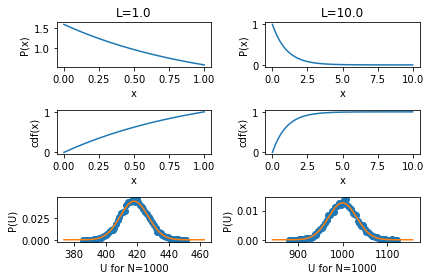

In [3]:
# %matplotlib notebook
%matplotlib inline

#Set up our IG model
mIG = IGmodel(nParticles=1000)

#And check some things out just with a test beta value, like 1.0 (just checking for right behavior)
testB = 1.0

#And at two different system sizes in its 1 dimension
#If L is not specified in the below functions, a default value of 1.0 is used
testL = [1.0, 10.0]

fig, ax = plt.subplots(3, 2)

for i, Lval in enumerate(testL):
    xvals = np.arange(0.0, Lval, 0.0001)

    #There are functions to sample both position and potential energy values
    uvals = mIG.sampleU(testB, s=10000, L=Lval)
    uhist, ubins = np.histogram(uvals, bins='auto', density=True)
    ubincents = 0.5*(ubins[:-1] + ubins[1:])
    
    #We can also just directly calculate the average or variance of the particle positions
    uavg = mIG.avgX(testB, L=Lval)*mIG.nP
    ustd = np.sqrt(mIG.varX(testB, L=Lval)*mIG.nP)
    utest = np.arange(uavg-5*ustd, uavg+5*ustd, 0.5)

    #Or you can get the probability distribution of x or U
    #For a full list of functions in the ideal gas model, just type help(mIG)
    ax[0,i].plot(xvals, mIG.PofX(xvals, testB, L=Lval))
    ax[1,i].plot(xvals, mIG.cdfX(xvals, testB, L=Lval))
    ax[2,i].plot(ubincents, uhist, 'o')
    ax[2,i].plot(utest, mIG.PofU(utest, testB, L=Lval))

    ax[0,i].set_xlabel('x')
    ax[0,i].set_ylabel('P(x)')
    ax[1,i].set_xlabel('x')
    ax[1,i].set_ylabel('cdf(x)')
    ax[2,i].set_xlabel('U for N=%s'%mIG.nP)
    ax[2,i].set_ylabel('P(U)')

ax[0,0].set_title('L=%2.1f'%testL[0])
ax[0,1].set_title('L=%2.1f'%testL[1])

fig.tight_layout()

plt.show()


The probability of a particle residing at a particular location is $\frac{e^{-\beta a x}}{\int_0^L e^{-\beta a x} dx}$, shown in the top panel. The cumulative distribution function, which is used to randomly sample from the distribution $P(x)$, is shown in the middle. From $N$ random draws of $x$ distributed according to $P(x)$, you have a single configuration with $N$ particles. The potential energy for a single configuration is $a \sum_i x_i$ and so by randomly sampling many configuraitons, we construct the potential energy distribution in the bottom panel. For a single particle, the potential energy distribution is identical to $P(x)$ since a single $x$ maps to exactly one potential energy. For many particles, however, the potential energy is a random variable composed of a sum of idependent random variables and so the distribution is Gaussian, as confirmed by the bottom panel.

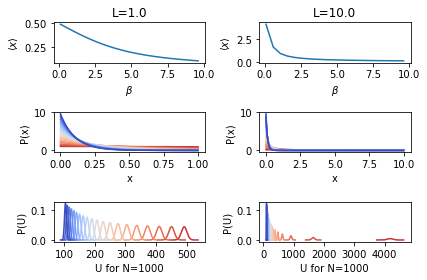

In [4]:
#Now look at behavior as a function of inverse temperature (at the same system sizes as above)

betavals = np.arange(0.1, 10.0, 0.5)

bcolors = plt.cm.coolwarm(np.arange(0.0, 1.0, float(1.0/len(betavals))))

fig, ax = plt.subplots(3, 2)

for i, Lval in enumerate(testL):
    xvals = np.arange(0.0, Lval, 0.0001)
    ax[0,i].plot(betavals, mIG.avgX(betavals, L=Lval))

    for j, B in enumerate(betavals):
        ax[1,i].plot(xvals, mIG.PofX(xvals, B, L=Lval), color=bcolors[-(j+1)])
        thisavg = mIG.nP*mIG.avgX(B, L=Lval)
        thisstd = np.sqrt(mIG.nP*mIG.varX(B, L=Lval))
        thisu = np.arange(thisavg-5*thisstd, thisavg+5*thisstd, 0.5)
        ax[2,i].plot(thisu, mIG.PofU(thisu, B, L=Lval), color=bcolors[-(j+1)])
    
    ax[0,i].set_xlabel(r'$\beta$')
    ax[0,i].set_ylabel(r'$\langle x \rangle$')
    ax[1,i].set_xlabel('x')
    ax[1,i].set_ylabel('P(x)')
    ax[2,i].set_xlabel('U for N=%s'%mIG.nP)
    ax[2,i].set_ylabel('P(U)')

ax[0,0].set_title('L=%2.1f'%testL[0])
ax[0,1].set_title('L=%2.1f'%testL[1])

fig.tight_layout()

plt.show()


A simple structural property of interest is the average $x$ value, which is plotted in the top panel as a function of $\beta$. It's only non-linear over a very large temperature range, but it's a toy system so the physical temperature really isn't relevant anyway. Changes in $P(x)$ and $P(U)$ with temperature are shown as well with coloring by temperature, NOT inverse temperature (blue is the lowest $T$, highest $\beta$). Clearly the configurational distributions will not overlap in their important regions and neither will the potential energy distributions, meaning perturbation won't work at some point. This is especially true as $L$ is increased.

Below, we show $\langle x \rangle$ as a function of $L$ at various temperatures. Non-linearities arise at all temperatures to varying degrees.

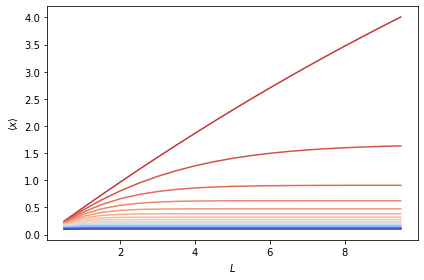

In [5]:
#Behavior of average x as a function of L

fig, ax = plt.subplots()

lvals = np.arange(0.5, 10.0, 0.5)

for i, B in enumerate(betavals):
    ax.plot(lvals, mIG.avgX(B, L=lvals), color=bcolors[-(i+1)], label=r'$\beta$ = %2.1f'%B)

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\langle x \rangle$')

fig.tight_layout()

plt.show()


## Extrapolation in temperature

### Case 1: Observable is an average with no explicit dependence on temperature

We first extrapolate the analytical model in temperature and compare to the exact result. We also compare results with finite numbers of samples to exact results for an infinite number of samples. This is possible because we can analytically calculate derivatives for the ideal gas model at any order rather than estimating them.

The first thing we want to do is define some parameters and generate data. We will define a reference inverse temperature, specific orders we want to extrapolate to, and create some reference data. The `genData` function of the `IGModel` class conveniently provides random samples of $x$ and $U$ data. This will be in the format of an array with `nConfigs` elements, each being the average $x$ value over $N$ independent ideal gas particles. The relevant potential energy is an array of the same shape with a single entry for each configuration. More generally, the data that should be provided to the extrapolation/interpolation code can have any number of columns but should have a single row associated with each simulation snapshot and potential energy. This allows for simultaneous extrapolation of all points in RDFs or time correlation functions with the interparticle distance or time varying with column. Or for simultaneous extrapolation of multiple observables. Critical, however, is that the potential energy (or Hamiltonian) is that which is appropriate to the snapshot with the same index. So for dynamical quantities like time correlation functions, the appropriate Hamiltonian is that for the starting configuration. Another main point here is that the number of columns is arbitrary, with each extrapolated separately, but because of the way the code is vectorized you get much better efficiency by providing multiple columns rather than running the extrapolation multiple times for different observables.

In [6]:
#Compare both perturbation and extrapolation in temperature to their analytical results

#Define reference beta
refBeta = betavals[11]

#Define orders to extrapolate to
extOrders = [1,2,4,6]

#Generate all the data we could want
xdata, udata = mIG.genData(refBeta, nConfigs=100000)


We now want to create and train our extrapolation and perturbation models that we will compare. By default the `ExtrapModel` or other classes work with the simplest case of directly extrapolating an observable that is an average quantity and does not explicitly depend on temperature. Note that this covers quantities that include dependence on kinetic degrees of freedom, with the potential energy simply substituted for the full Hamiltonian (total energy). Or it works for extrapolating in temperature or pressure in the NPT ensemble - again you just have to insert the appropriate Hamiltonian instead of the potential energy. We will handle the case of explicit temperature dependence later on.

In [7]:
#Create extrapolation and perturbation models
extModel = ExtrapModel(maxOrder=extOrders[-1])
pertModel = PerturbModel()

#Train on the full dataset
extParams = extModel.train(refB=refBeta, xData=xdata, uData=udata, saveParams=True)
pertParams = pertModel.train(refB=refBeta, xData=xdata, uData=udata, saveParams=True)


In the above, we first create the objects, then train them. If you instead pass all but the `saveParams` argument when creating the models, they will automatically train themselves on the data provided. During initiation of extrapolation models, sympy is used to calculate all symbolic derivatives up to the desired order. Going to higher orders is really the time consuming bit, so we try and do it as few times as possible. This is not needed for perturbation as there is no sense of truncating at a certain order.

The `train` function returns the parameters. For extrapolation, these are the numerical values of the derivatives up to the specified maximum order for each element of a vector observable. For perturbation, the parameters are just the data itself, as all of it is needed to make a calculation through reweighting. The `saveParams` argument tells whether or not the class should make the calculated parameters the default for that object. Typically, you want this to be the case so that you can then just use the object to make predictions (shown next). You'll want to set this to `False`, however, if you just want to make a one-off parameter estimate or prediction with a subset of the data or altered dataset, as is the case when bootstrapping.

Let's test some predictions and look at the results. Notice that you can make predictions over scalars or arrays of values, but the extrapolation will only be 1D in the variable of interest (e.g. temperature, pressure, etc.). Extrapolations in multiple dimensions of state variables is not yet supported.

In [8]:
#Make some predictions
print("Extrapolation prediction: ", extModel.predict(betavals[0]))
print("Perturbation prediction : ", pertModel.predict(betavals[0]))
print('\n')

#By default, uses maximum order, but can switch to any lower order if desired
#Remember, order doesn't matter for perturbation
print("At lower order...")
print("Extrapolation: ", extModel.predict(betavals[0], order=2))
print("Perturbation : ", pertModel.predict(betavals[0]))
print('\n')

#Can also make predictions for multiple values
print("For multiple beta values...")
print("Extrapolation:")
print(extModel.predict(betavals[:4], order=2))
print("Perturbation :")
print(pertModel.predict(betavals[:4]))
print('\n')

#When making predictions, can also take parameters instead of using those saved by saveParams=True
print("Providing (the same) parameters...")
print("Extrapolation: ", extModel.predict(betavals[0], order=2, params=extParams))
print("Perturbation : ", pertModel.predict(betavals[0], params=pertParams))


Extrapolation prediction:  [[-556.79478684]]
Perturbation prediction :  [[0.1979068]]


At lower order...
Extrapolation:  [[0.4715475]]
Perturbation :  [[0.1979068]]


For multiple beta values...
Extrapolation:
[[0.4715475 ]
 [0.43278737]
 [0.39638484]
 [0.36233991]]
Perturbation :
[[0.1979068 ]
 [0.1978923 ]
 [0.19787428]
 [0.19785139]]


Providing (the same) parameters...
Extrapolation:  [[0.4715475]]
Perturbation :  [[0.1979068]]


Note that the output shape has its first dimension as the length of the array of values at which we want predictions and its second dimension being the length of the observable array. This is more clear if we add an extra dimension to our data...

In [9]:
#Create and train extrapolation model with 2D data
extModel2D = ExtrapModel(maxOrder=extOrders[-1], refB=refBeta, xData=np.array([xdata, xdata**2]).T, uData=udata)

#Check the parameters - should be same for first dimension
print("Parameters (derivatives) for 1D model: ")
print(extParams)
print("Parameters for 2D model: ")
print(extModel2D.params)
print('\n')

#Finally, look at predictions
print("2D extrapolation predictions:")
print(extModel2D.predict(betavals[:4], order=2))


Parameters (derivatives) for 1D model: 
[[ 1.74854078e-01]
 [-2.80106599e-02]
 [ 9.43039920e-03]
 [-9.97728319e-04]
 [ 7.35027492e-02]
 [-1.89036179e+00]
 [-1.66308594e+01]]
Parameters for 2D model: 
[[ 1.74854078e-01  3.06019594e-02]
 [-2.80106599e-02 -9.80498666e-03]
 [ 9.43039920e-03  4.86807939e-03]
 [-9.97728319e-04 -2.00732666e-03]
 [ 7.35027492e-02  2.83524320e-02]
 [-1.89036179e+00 -6.65284157e-01]
 [-1.66308594e+01 -6.17517090e+00]]


2D extrapolation predictions:
[[0.4715475  0.15815909]
 [0.43278737 0.14047789]
 [0.39638484 0.1240137 ]
 [0.36233991 0.10876654]]


All of the extrapolation/interpolation model classes come with a bootstrap function that will resample the passed in data and return the standard deviation of the bootstrapped estimates (default resamples is $n=100$). Each time a data sample is drawn, the parameters are recomputed (i.e. model is retrained) but not saved and the resulting parameters are used to evaluate the model at the specified state points. Passing in no values at which to make predictions will instead return boostrapped estimates of the error in the parameters themselves (i.e. derivatives for extrapolation or polynomial coefficients for interpolation). Uncertainty estimates are returned with the same shapes as predictions themselves. When estimating the uncertainty in parameters, the dimensions are the derivative (or polynomial) order and the observable vector.

In [10]:
#Get bootstrapped error at a series of data points at a specified order with 1000 draws from the original data
print("Bootstrapped error for predictions with 2D model:")
print(extModel2D.bootstrap(betavals[:4], order=2, n=1000))
print('\n')

#Now get bootstrapped uncertainty in the parameters up to maximum order with only 100 draws (the default)
print("Bootstrapped error in parameters (derivatives) with 2D model:")
print(extModel2D.bootstrap([]))


Bootstrapped error for predictions with 2D model:
[[0.0177571  0.00629879]
 [0.01468625 0.00521061]
 [0.01190696 0.00422563]
 [0.00941924 0.00334385]]


Bootstrapped error in parameters (derivatives) with 2D model:
No state points provided to boostrap prediction at - bootstrapping parameters.
[[1.64985549e-05 5.79735942e-06]
 [1.27681037e-04 4.49910525e-05]
 [1.14693309e-03 4.05260927e-04]
 [1.29618098e-02 4.61514810e-03]
 [1.34310135e-01 4.82447210e-02]
 [1.86428520e+00 6.67139569e-01]
 [2.25825621e+01 8.20530163e+00]]


It's finally time to do something interesting. Now we will loop over different numbers of samples (in sets randomly drawn from the data we generated earlier) and extrapolation orders and compare the performance of extrapolation and perturbation to the analytical result.

True extrapolation coefficients: [ 0.17485984 -0.02816239  0.00763547 -0.00229234  0.00043704  0.00025699
 -0.0004418 ]
	 With N_configs =     10: [ 1.72705489e-01 -2.31157150e-02  5.81640463e-02 -4.20466326e-01
 -2.42004126e+00  1.53230785e+02 -1.38265039e+03]
	 With N_configs =    100: [ 1.74878773e-01 -2.59950035e-02 -6.57034420e-03  3.24857222e-01
  1.33077592e-01 -1.42661285e+01  7.59912109e+01]
	 With N_configs =   1000: [ 1.74594911e-01 -2.91866367e-02  4.84672691e-02 -5.36018308e-02
 -1.78931919e+00  3.07068710e+01 -3.39125977e+02]
	 With N_configs =  10000: [ 1.74857314e-01 -2.83556075e-02  1.51961198e-02  3.70051739e-02
 -2.40987390e-01 -1.09947472e+01  9.91962891e+01]
	 With N_configs = 100000: [ 1.74854078e-01 -2.80106599e-02  9.43039919e-03 -9.97728785e-04
  7.35029876e-02 -1.89097595e+00 -1.47304688e+01]


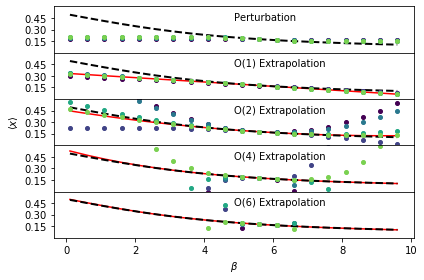

In [11]:
fig, ax = plt.subplots(len(extOrders)+1, sharex=True, sharey=True)

nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
for a in ax:
    a.plot(betavals, mIG.avgX(betavals), 'k--', linewidth=2.0)

#Next look at extrapolation with an infinite number of samples
#This is possible in the ideal gas model in both temperature and volume
for j, o in enumerate(extOrders):
    trueExtrap, trueDerivs = mIG.extrapAnalytic(betavals, refBeta, o)
    ax[j+1].plot(betavals, trueExtrap, 'r-', zorder=0)
    if j == len(extOrders)-1:
        print('True extrapolation coefficients: %s'%str(trueDerivs))

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdata), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    thisext = extModel.train(refBeta, xdata[thisinds], udata[thisinds], saveParams=False)
    print('\t With N_configs = %6i: %s'%(n, str(thisext.flatten()))) #Have to flatten because observable is 1-D
    for j, o in enumerate(extOrders):
        dataExtrap = extModel.predict(betavals, params=thisext, order=o)
        ax[j+1].plot(betavals, dataExtrap, 'o', markersize=4, color=nsampcolors[i], label='N=%i'%n)
    
    #And do the same thing for perturbation, but here the parameters are just the data
    thispert = pertModel.train(refBeta, xdata[thisinds], udata[thisinds], saveParams=False)
    dataPert = pertModel.predict(betavals, params=thispert)
    ax[0].plot(betavals, dataPert, 'o', markersize=4, color=nsampcolors[i])

ax[2].set_ylabel(r'$\langle x \rangle$')
ax[-1].set_xlabel(r'$\beta$')

ax[0].annotate('Perturbation', xy=(0.5, 0.7), xycoords='axes fraction')
for j, o in enumerate(extOrders):
    ax[j+1].annotate('O(%i) Extrapolation'%(o), xy=(0.5, 0.7), xycoords='axes fraction')

ax[-1].set_ylim((0.0, 0.6))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()


In each of the figures, the true behavior is shown as a black dashed line, the analytical result (infinite sampling) for each order of extrapolation is shown as a red solid line and the results with 10, 100, 1000, ... 100000 randomly sampled configurations are shown with purple (fewer samples) to green (more samples) circles. Perturbation works close to the reference temperature, but saturates far away. With more samples, it works further out, but the increases in accuracy are marginal. First order extrapolation quickly converges to the infinite sampling limit while second order takes more sampling to do so. The actual coefficients at each order of extrapolation are printed below. Since perturbation essentially refuses to provide an estimate past a certain distance in $\beta$, it is not reliable some distance out. Both first and second order extrapolation essentially get lucky here and remain highly accurate over very large temperature ranges. For higher order extrapolation, the analytical, infinite sampling result matches very closely with the true temperature dependence of $\langle x \rangle$. However, the finite-sampling results are in practice very poor due to difficulties in accurately estimating the higher-order moments of the potential energy distribution. The higher orders are actually quite accurate (if you try zooming in) close to the point we're extrapolating from, but the error grows very quickly as we move further away.

To get a sense for when/why perturbation fails, we can look at ratios of probability distributions.

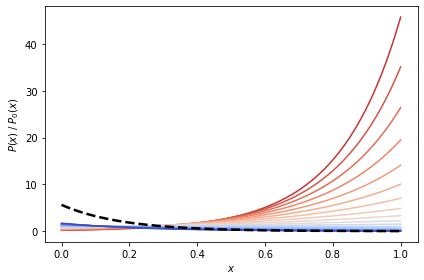

In [12]:
fig, ax = plt.subplots()

xvals = np.arange(0.0, 1.0, 0.0001)

for i, B in enumerate(betavals):
    ax.plot(xvals, mIG.PofX(xvals, B)/mIG.PofX(xvals, refBeta), color=bcolors[-(i+1)])

ax.plot(xvals, mIG.PofX(xvals, refBeta), 'k--', linewidth=2.5)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$P(x) \; / \; P_{0}(x)$')

fig.tight_layout()

plt.show()


The above shows the ratio of probabilities at the perturbed temperature to the reference temperature and gives a better sense for why perturbation fails. Where the ratio of weights is large is where we need to sample because this is the part of phase space that is important to the state we're perturbing to that is not sampled in the reference state. It's also where the ratio of weights itself will contribute the most to its average. This is critical because perturbation relies on accurately computing both the average of the quantity of interest multiplied by the weight ratio (the numerator) and the weight ratio itself (the denominator). If we compare to the reference $P(x)$ (shown as a dashed line), we see that where we actually sample configurations from is nowhere close to what's important in the ratio of weights. Perturbation is then the same as only averaging (integrating) the ratio up to a certain point, limited by sampling. By truncating at that point, you don't get a good estimate of the true average of the ratio of weights. You also can't possibly get a good estimate of the numerator in perturbation, which is the average of the quantity of interest multiplied by the ratio of weights. Perturbation effectively tries to compensate for sampling from the wrong region by multiplying the observable of interest by the ratio of weights when averaging. This still won't be enough because you can't accurately estimate the ratio of weights if you don't sample fully. The end result is that you just get stuck with configurations only relevant to the reference ensemble and your estimate won't change even as you move further away.

### Case 2: Observable is an average with explicit temperature dependence

This is a more difficult case because the derivatives are more complicated. However, this case has also been coded in the library. Modifications do need to be made to the base classes, but this is relatively easy to do and will also be the basis for extrapolating quantities that involve natural logarithms or extrapolating in volume.

The extrapolation and interpolation model classes all have methods called `calcDerivFuncs` and `calcDerivVals` (the MBAR and perturbation classes do not, obviously). The first of these functions typically calculates symbolic derivatives to the desired order and returns "lambdified" numpy functions. These functions take as input moments of the potential energy and observable used in extrapolation and output derivatives at a specific order. What's more important is the `calcDerivVals` function because it takes raw data and uses this, along with the results of `calcDerivFuncs`, to calculate and return actual derivative values. We must change both of these methods in order to incorporate temperature dependence. In what is below, we've mostly just reproduced both methods from the `ExtrapModel` class. We only need to change one or two lines in each of these functions because methods to calculate symbolic derivatives and appropriate potential energy moments have already been coded.

In [13]:
#Need to import from utilities
from thermoextrap.utilities import symDerivAvgXdependent, buildAvgFuncsDependent

class ExtrapModelDependent(ExtrapModel):
    """Class to hold information about an extrapolation that is dependent on the extrapolation variable.
    """

    #Calculates symbolic derivatives up to maximum order given data
    #Returns list of functions that can be used to evaluate derivatives for specific data
    def calcDerivFuncs(self):
        derivs = []
        for o in range(self.maxOrder+1):
            derivs.append(symDerivAvgXdependent(o)) #Only changing this line to get dependent information
        return derivs

    #And given data, calculate numerical values of derivatives up to maximum order
    #Will be very helpful when generalize to different extrapolation techniques
    #(and interpolation)
    def calcDerivVals(self, refB, x, U):
        """Calculates specific derivative values at B with data x and U up to max order.
        Returns these derivatives.
        """
        if x.shape[0] != U.shape[0]:
            print('First observable dimension (%i) and size of potential energy array (%i) don\'t match!'%(x.shape[0], U.shape[0]))
            return
        
        avgUfunc, avgXUfunc = buildAvgFuncsDependent(x, U, self.maxOrder) #Change this line to use dependent function
        derivVals = np.zeros((self.maxOrder+1, x.shape[2])) #And change this line because x data is of different shape
        for o in range(self.maxOrder+1):
            derivVals[o] = self.derivF[o](avgUfunc, avgXUfunc)
            
        return derivVals


For our observable that depends explicitly on temperature, we select the average dimensionless potential energy of a single ideal gas particle, $\beta u = \langle \beta a x \rangle = \langle \beta x \rangle$ where $a=1$ for simplicity. The average is over all particles and configurations. 

Everything can be set up in pretty much the same way. EXCEPT that we now have to provide not only data for the observable, but also its derivatives in $\beta$. The derivatives must be supplied up to the desired maximum order. This is a bit cumbersome in general, but it is rare to have explicit temperature dependence except polynomial or exponential dependence on $\beta$, as in the case when computing excess chemical potentials. In these cases, derivatives of arbitrarily high order are trival to compute. 

So now the observable data can have 3 dimensions - for each configurational snapshot, for each derivative order starting at zero (i.e. the observable value) and going to the maximum desired, and for each element in the observable array.  

In [14]:
#Make sure to include observable derivatives with beta
#First dimension is number configurational snapshots, second number derivatives, last is dimension of observable
xdataDepend = np.array([xdata*refBeta, xdata]).T
xdataDepend = np.hstack((xdataDepend, np.zeros((xdata.shape[0],extOrders[-1]-1))))
xdataDepend = np.reshape(xdataDepend, xdataDepend.shape+(1,))

#Create and train extrapolation model
extModelDependent = ExtrapModelDependent(maxOrder=extOrders[-1], refB=refBeta, xData=xdataDepend, uData=udata)

#Check the parameters
print("Model parameters (derivatives):")
print(extModelDependent.params)
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(extModelDependent.predict(betavals[:4], order=2))
print('\n')

#And bootstrapped uncertainties
print("Bootstrapped uncertainties in predictions:")
print(extModelDependent.bootstrap(betavals[:4], order=2))


Model parameters (derivatives):
[[ 9.79182839e-01]
 [ 1.79943829e-02]
 [-3.21108434e-03]
 [ 2.27039144e-02]
 [ 4.07629042e-01]
 [-1.02261415e+01]
 [-1.14079346e+02]]


Model predictions:
[[0.83164608]
 [0.84907237]
 [0.86569589]
 [0.88151663]]


Bootstrapped uncertainties in predictions:
[[0.10170143]
 [0.08409463]
 [0.06816136]
 [0.05390163]]


True extrapolation coefficients: [ 9.79215103e-01  1.71504528e-02 -1.35661750e-02  1.00692980e-02
 -6.72191329e-03  3.62437174e-03 -9.32132566e-04]
	 With N_configs =     10: [ 9.71996300e-01  4.21882549e-02  4.33098680e-01  2.27602598e+00
 -6.29288082e+01  1.77486287e+02  1.49147615e+04]
	 With N_configs =    100: [ 9.77892890e-01  2.55454572e-02 -1.16161861e-01  1.16523882e+00
  1.06978973e+01  3.88651407e+01 -1.60455417e+03]
	 With N_configs =   1000: [ 9.78350186e-01  3.15816571e-02 -1.15700226e-01  3.00321806e-01
  2.84613152e+00  8.12156394e+01 -9.63859253e+01]
	 With N_configs =  10000: [ 9.79473377e-01  1.62953607e-02  1.10924172e-02 -1.81757584e-01
  2.02998627e+00 -4.62334335e+01 -7.35306488e+02]
	 With N_configs = 100000: [ 9.79182839e-01  1.79943829e-02 -3.21108435e-03  2.27039135e-02
  4.07627970e-01 -1.02146361e+01 -1.15149658e+02]


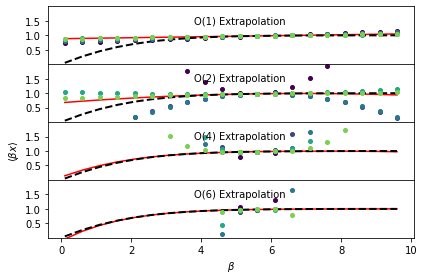

In [15]:
fig, ax = plt.subplots(len(extOrders), sharex=True, sharey=True)

nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
for a in ax:
    a.plot(betavals, betavals*mIG.avgX(betavals), 'k--', linewidth=2.0)

#And the infinite sampling results for each extrapolation order
#Hard-coding analytic extrapolation for the specific case of <B*x> here because it's simple and nice to check
trueDerivs = np.zeros(np.max(extOrders)+1)
for o in range(np.max(extOrders)+1):
    if o == 0:
        trueDerivs[o] = (refBeta*(mIG.avgX(refBeta)))
        continue
    trueDerivs[o] = (o*mIG.avgXsym.diff(mIG.b, o-1).subs({mIG.b:refBeta, mIG.l:1.0})
                     + refBeta*mIG.avgXsym.diff(mIG.b, o).subs({mIG.b:refBeta, mIG.l:1.0}))
print('True extrapolation coefficients: %s'%str(trueDerivs))

#Now need to loop to get actual extrapolation values with analytical derivatives
for j, o in enumerate(extOrders):
    trueExtrap = 0.0
    for k in range(o+1):
        trueExtrap += trueDerivs[k]*((betavals-refBeta)**k)/np.math.factorial(k)
    ax[j].plot(betavals, trueExtrap, 'r-', zorder=0)

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdata), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    thisext = extModelDependent.train(refBeta, xdataDepend[thisinds], udata[thisinds], saveParams=False)
    print('\t With N_configs = %6i: %s'%(n, str(thisext.flatten()))) #Have to flatten because observable is 1-D
    for j, o in enumerate(extOrders):
        dataExtrap = extModelDependent.predict(betavals, params=thisext, order=o)
        ax[j].plot(betavals, dataExtrap, 'o', markersize=4, color=nsampcolors[i], label='N=%i'%n)

ax[2].set_ylabel(r'$\langle \beta x \rangle$')
ax[-1].set_xlabel(r'$\beta$')

for j, o in enumerate(extOrders):
    ax[j].annotate('O(%i) Extrapolation'%(o), xy=(0.4, 0.7), xycoords='axes fraction')

ax[-1].set_ylim((0.0, 2.0))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()


### Case 3: Observable is the negative logarithm of an average with no explicit temperature dependence

Modifications for this case will be very similar to those in the case of an average with explicit temperature dependence. We only need to modify `calcDerivVals` this time because we want the same symbolic derivatives, we will just combine them in a different way that reflects a generalization of the chain rule (i.e. Fa\`a di Bruno's formula applied to the logarithm of a function).

This type of extrapolation is useful for extrapolating hard-sphere chemical potentials in temperature or volume, or other quantities involving logarithms of probabilities (e.g. PMFs).

In [16]:
from thermoextrap.utilities import buildAvgFuncs

#For quantities like the chemical potential, we're interested in the -log(<X>), not <X>
#Everything is the same, but we take derivatives differently
#Luckily, have closed-form expression for derivatives of -log(<X>) in terms of derivatives of <X>
#Specifically, d(n)[-log(<X>)]/dB(n) = Sum(k=1, n)[(k-1)! * (-1/<X>)^k * B(n,k,(d<X>/dB, ..., d(n-k+1)<X>/dB(n-k+1)))]
#B(n,k, (...)) represents Bell Polynomials, which are implemented in sympy (not numpy or scipy unfortunately)
#Create custom classes to handle this
from sympy import bell

class LogAvgExtrapModel(ExtrapModel):
    
    def calcDerivVals(self, refB, x, U):
        
        if x.shape[0] != U.shape[0]:
            print('First observable dimension (%i) and size of potential energy array (%i) do not match!'%(x.shape[0], U.shape[0]))
            return
    
        avgUfunc, avgXUfunc = buildAvgFuncs(x, U, self.maxOrder)
        derivVals = np.zeros((self.maxOrder+1, x.shape[1]))
        for o in range(self.maxOrder+1):
            if o == 0:
                derivVals[o] = (-np.log(avgXUfunc(0)))
                continue
            for k in range(1,o+1):
                #Get the derivatives of the average quantity
                thisDiffs = np.array([self.derivF[l](avgUfunc, avgXUfunc) for l in range(1, o-k+2)])
                #Loop to apply the chain rule to each element of the observable array
                for l in range(x.shape[1]):
                    derivVals[o,l] += np.math.factorial(k-1)*((-1/avgXUfunc(0)[l])**k)*bell(o, k, thisDiffs[:,l])
                
        return derivVals


In [17]:
#Create and train extrapolation model
extModelLog = LogAvgExtrapModel(maxOrder=extOrders[-1], refB=refBeta, xData=xdata, uData=udata)

#Note that we handled the -log calculation in the definition of the derivatives (even at zeroth order).
#This means we want to just pass data, not the -log of the data.

#Check the parameters
print("Model parameters (derivatives):")
print(extModelLog.params)
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(extModelLog.predict(betavals[:4], order=2))
print('\n')

#And bootstrapped uncertainties
print("Bootstrapped uncertainties in predictions:")
print(extModelLog.bootstrap(betavals[:4], order=2))


Model parameters (derivatives):
[[ 1.74380349e+00]
 [ 1.60194490e-01]
 [-2.82706921e-02]
 [-1.19913197e-02]
 [-4.20640810e-01]
 [ 1.04774394e+01]
 [ 1.05522407e+02]]


Model predictions:
[[0.43513958]
 [0.58944739]
 [0.73668753]
 [0.87685999]]


Bootstrapped uncertainties in predictions:
[[0.10325827]
 [0.08542397]
 [0.06928018]
 [0.05482688]]


True extrapolation coefficients: [ 1.74377054e+00  1.61056939e-01 -1.77268660e-02  3.66764737e-04
  2.11140145e-03 -1.53768224e-03  3.99266294e-04]
	 With N_configs =     10: [ 1.74890241e+00  1.94062515e-01  6.82323776e-01 -1.41034621e+00
 -1.11189414e+02 -1.17695474e+03  2.24984501e+04]
	 With N_configs =    100: [ 1.74479595e+00  1.51566720e-01  7.47826189e-02 -1.63333745e+00
 -1.30722955e+01  1.09652651e+02  2.29248057e+03]
	 With N_configs =   1000: [ 1.74545692e+00  1.59052725e-01  8.68276761e-02  6.40243714e-01
 -3.85781019e+00 -1.27099096e+02  9.88595915e+01]
	 With N_configs =  10000: [ 1.74330202e+00  1.61575377e-01 -5.53537926e-02 -1.40879906e-01
  8.14562029e-01  1.55438304e+01 -1.31934223e+02]
	 With N_configs = 100000: [ 1.74380349e+00  1.60194490e-01 -2.82706921e-02 -1.19913224e-02
 -4.20636210e-01  1.04681929e+01  9.81133720e+01]


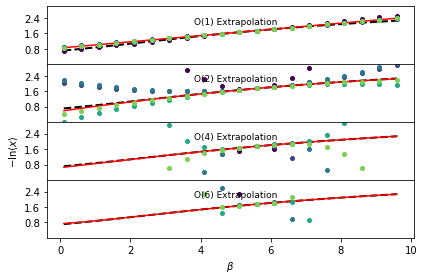

In [18]:
#Repeat comparison of results, but for -ln<x> instead of <x>

fig, ax = plt.subplots(len(extOrders), sharex=True, sharey=True)

#nsampvals = np.geomspace(10, len(xdata), num=4, dtype=int)
nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
for a in ax:
    a.plot(betavals, -np.log(mIG.avgX(betavals)), 'k--', linewidth=2.0)

#And the infinite sampling results for each extrapolation order
#Must carefully calculate derivatives with Faa di Bruno's formula, then manually do extrapolation
#Again hard-coded and not explicitly part of IGModel class
trueDerivs = np.zeros(np.max(extOrders)+1)
for o in range(np.max(extOrders)+1):
    if o == 0:
        trueDerivs[o] = (-np.log(mIG.avgX(refBeta)))
        continue
    for k in range(1,o+1):
        thisDiffs = np.array([mIG.avgXsym.diff(mIG.b, l).subs({mIG.b:refBeta, mIG.l:1.0}) for l in range(1, o-k+2)])
        trueDerivs[o] += np.math.factorial(k-1)*((-1/mIG.avgX(refBeta))**k)*bell(o, k, thisDiffs)
print('True extrapolation coefficients: %s'%str(trueDerivs))

#Loop to get actual analytical extrapolations based on derivatives
for j, o in enumerate(extOrders):
    trueExtrap = 0.0
    for k in range(o+1):
        trueExtrap += trueDerivs[k]*((betavals-refBeta)**k)/np.math.factorial(k)
    ax[j].plot(betavals, trueExtrap, 'r-')

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdata), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    thisext = extModelLog.train(refBeta, xdata[thisinds], udata[thisinds], saveParams=False)
    print('\t With N_configs = %6i: %s'%(n, str(thisext.flatten()))) #Have to flatten because observable is 1-D
    for j, o in enumerate(extOrders):
        dataExtrap = extModelLog.predict(betavals, params=thisext, order=o)
        ax[j].plot(betavals, dataExtrap, 'o', markersize=4, color=nsampcolors[i], label='N=%i'%n)

ax[2].set_ylabel(r'$-\mathrm{ln} \langle x \rangle$')
ax[-1].set_xlabel(r'$\beta$')

for j, o in enumerate(extOrders):
    ax[j].annotate('O(%i) Extrapolation'%(o), xy=(0.4, 0.7), xycoords='axes fraction', fontsize=9)

ax[0].set_ylim((0.0, 3.0))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()


### Case 4: Observable is the negative logarithm of an average with explicit temperature dependence

At this point it should be clear that this is possible and only slightly more annoying to implement. This will come up any time you have computed a free energy change, such as solvation, via exponential averaging at one temperature and want to extrapolate it to another temperature. Note that free energy differences calculated by any method at a given temperature may also be extrapolated using differences in moments of the potential energies between the beginning and end states along the thermodynamic path. This may be more efficient, but we has not been investigated and we present the current case merely as another example.

We have to modify both `calcDerivFuncs` and `calcDerivVals` the same way we did for Case 2. We also need to add in the chain rule trick from Case 3.

As a quick tutorial to inheritance of classes in python, we do this by inheriting from `ExtrapModelDependent` that we created earlier. By doing this, we only need to modify `calcDerivVals` since `calcDerivFuncs` will already be updated to reflect temperature dependence of the symbolic derivatives. This basic feature of python is why it's so quick and easy to customize the libExtrap library however you want. You still get the power of other methods in the class as long as the outputs from the methods you modify are what is expected by the class.

In [19]:
from thermoextrap.utilities import buildAvgFuncsDependent

class LogAvgExtrapModelDependent(ExtrapModelDependent):
    """Class to hold information about an extrapolation that is dependent on the extrapolation variable and
    involves the negative logarithm of an average.
    """

    def calcDerivVals(self, refB, x, U):
        """Calculates specific derivative values at B with data x and U up to max order.
        Returns these derivatives.
        """
        if x.shape[0] != U.shape[0]:
            print('First observable dimension (%i) and size of potential energy array (%i) don\'t match!'%(x.shape[0], U.shape[0]))
            return
        
        avgUfunc, avgXUfunc = buildAvgFuncsDependent(x, U, self.maxOrder) #Change this line to use dependent function
        derivVals = np.zeros((self.maxOrder+1, x.shape[2])) #And change this line because x data is of different shape
        for o in range(self.maxOrder+1):
            if o == 0:
                derivVals[o] = (-np.log(avgXUfunc(0,0))) #First index is derivative of function, next is power on U
                continue
            for k in range(1,o+1):
                #Get the derivatives of the average quantity
                thisDiffs = np.array([self.derivF[l](avgUfunc, avgXUfunc) for l in range(1, o-k+2)])
                #Loop to apply the chain rule to each element of the observable array
                for l in range(x.shape[2]):
                    derivVals[o,l] += np.math.factorial(k-1)*((-1/avgXUfunc(0,0)[l])**k)*bell(o, k, thisDiffs[:,l])
            
        return derivVals


In [20]:
#Create and train extrapolation model
extModelLogDepend = LogAvgExtrapModelDependent(maxOrder=extOrders[-1], refB=refBeta, xData=xdataDepend, uData=udata)

#Note that we handled the -log calculation in the definition of the derivatives (even at zeroth order).
#This means we want to just pass data, not the -log of the data.

#Check the parameters
print("Model parameters (derivatives):")
print(extModelLogDepend.params)
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(extModelLogDepend.predict(betavals[:4], order=2))
print('\n')

#And bootstrapped uncertainties
print("Bootstrapped uncertainties in predictions:")
print(extModelLogDepend.bootstrap(betavals[:4], order=2))


Model parameters (derivatives):
[[ 2.10368924e-02]
 [-1.83769386e-02]
 [ 3.61706299e-03]
 [-2.33797990e-02]
 [-4.14544494e-01]
 [ 1.04808734e+01]
 [ 1.15333987e+02]]


Model predictions:
[[0.17681813]
 [0.15813487]
 [0.14035588]
 [0.12348115]]


Bootstrapped uncertainties in predictions:
[[0.10426902]
 [0.08619441]
 [0.06984045]
 [0.05520714]]


True extrapolation coefficients: [ 0.02100394 -0.01751449  0.01416089 -0.01102172  0.00821238 -0.00589552
  0.00429019]
	 With N_configs =     10: [ 1.78210215e-02  4.04592838e-02  1.03810929e-01 -1.05631854e+01
  7.34712264e+00  2.54276423e+03 -6.40109586e+03]
	 With N_configs =    100: [ 2.36566752e-02 -3.19864573e-02 -9.87167385e-02 -5.46979620e-01
  6.40577171e+00 -8.45011234e+01 -2.05254617e+02]
	 With N_configs =   1000: [ 2.05138118e-02 -1.30810537e-02 -1.59702352e-02  7.12115603e-01
 -1.99213561e+00 -1.70732036e+02  7.79256380e+02]
	 With N_configs =  10000: [ 2.06871004e-02 -1.91243152e-02 -4.45386543e-03 -1.92972285e-01
  2.75304215e+00  2.04841096e+01 -2.28637759e+02]
	 With N_configs = 100000: [ 2.10368924e-02 -1.83769386e-02  3.61706300e-03 -2.33798009e-02
 -4.14537432e-01  1.04754499e+01  9.89824930e+01]


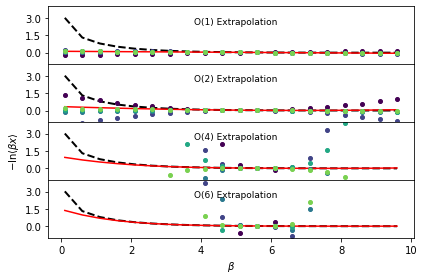

In [21]:
#Repeat comparison of results, but for -ln<B*x>, the most complicated case

fig, ax = plt.subplots(len(extOrders), sharex=True, sharey=True)

#nsampvals = np.geomspace(10, len(xdata), num=4, dtype=int)
nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
for a in ax:
    a.plot(betavals, -np.log(betavals*mIG.avgX(betavals)), 'k--', linewidth=2.0)

#And the infinite sampling results for each extrapolation order
#Must carefully calculate derivatives with Faa di Bruno's formula, then manually do extrapolation
#Again hard-coded for just -ln<B*x> and not explicitly part of IGModel class
trueDerivs = np.zeros(np.max(extOrders)+1)
for o in range(np.max(extOrders)+1):
    if o == 0:
        trueDerivs[o] = -np.log(refBeta*(mIG.avgX(refBeta)))
        continue
    trueDerivs[o] += np.math.factorial(o-1)*((-1.0/refBeta)**o) 
    for k in range(1,o+1):
        thisDiffs = np.array([mIG.avgXsym.diff(mIG.b, l).subs({mIG.b:refBeta, mIG.l:1.0}) for l in range(1, o-k+2)])
        trueDerivs[o] += np.math.factorial(k-1)*((-1/mIG.avgX(refBeta))**k)*bell(o, k, thisDiffs)
print('True extrapolation coefficients: %s'%str(trueDerivs))

#Loop to get actual analytical extrapolations based on derivatives
for j, o in enumerate(extOrders):
    trueExtrap = 0.0
    for k in range(o+1):
        trueExtrap += trueDerivs[k]*((betavals-refBeta)**k)/np.math.factorial(k)
    ax[j].plot(betavals, trueExtrap, 'r-')

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdata), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    thisext = extModelLogDepend.train(refBeta, xdataDepend[thisinds], udata[thisinds], saveParams=False)
    print('\t With N_configs = %6i: %s'%(n, str(thisext.flatten()))) #Have to flatten because observable is 1-D
    for j, o in enumerate(extOrders):
        dataExtrap = extModelLogDepend.predict(betavals, params=thisext, order=o)
        ax[j].plot(betavals, dataExtrap, 'o', markersize=4, color=nsampcolors[i], label='N=%i'%n)

ax[2].set_ylabel(r'$-\mathrm{ln} \langle \beta x \rangle$')
ax[-1].set_xlabel(r'$\beta$')

for j, o in enumerate(extOrders):
    ax[j].annotate('O(%i) Extrapolation'%(o), xy=(0.4, 0.7), xycoords='axes fraction', fontsize=9)

ax[0].set_ylim((-1.0, 4.0))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()


## Extrapolation in volume

Using the same tricks as above, it is also possible to adjust the `calcDerivVals` function to instead compute derivatives with respect to volume (or for the ideal gas, the single dimension length). A `VolumeExtrapModel` class is already present in the library to extrapolate up to first order in volume (any further and you need derivatives of forces). We do not use this class here and instead effectively reproduce it for pedogogical purposes. Additionally, the provided class simply ignores the unique contribution to the first derivative that is observable dependent. We include this term here so that you can play around with removing it. Though this term is orders of magnitude smaller than the other two terms in the expression for first-order derivatives in volume, it can be significant due to near cancellation of the other two large terms. This is the case for the ideal gas system here, but should be checked for any system.

In [22]:
class VolumeExtrapModelIG(ExtrapModel):
    """Class to hold information about an extrapolation in size for a 1D system (e.g. our ideal gas model)
    """

    #Can't go to higher order in practice, so don't return any symbolic derivatives
    #Instead, just use this to check and make sure not asking for order above 1
    def calcDerivFuncs(self):
        if self.maxOrder > 1:
            print('Volume extrapolation cannot go above 1st order without derivatives of forces.')
            print('Setting order to 1st order.')
            self.maxOrder = 1
        return None

    #And given data, calculate numerical values of derivatives up to maximum order
    #Will be very helpful when generalize to different extrapolation techniques
    #(and interpolation)
    def calcDerivVals(self, refL, x, W):
        """Calculates specific derivative values at B with data x and U up to max order.
        Returns these derivatives. Only go to first order for volume extrapolation. And
        here W represents the virial instead of the potential energy.
        """

        if x.shape[0] != W.shape[0]:
            print('First observable dimension (%i) and size of potential energy array (%i) don\'t match!'%(x.shape[0], W.shape[0]))
            return
        
        wT = np.array([W]).T
        avgX = np.average(x, axis=0)
        avgW = np.average(W)
        avgXW = np.average(x*wT, axis=0)
        derivVals = np.zeros((2, x.shape[1]))
        derivVals[0] = avgX
        derivVals[1] = (avgXW - avgX*avgW) / refL
        #Add the unique correction for the observable <x> in the ideal gas system
        #It turns out this is just <x> itself divided by L
        derivVals[1] += avgX / refL

        return derivVals


To extrapolate in volume we need observable values at each snapshot along with values of the virial at each snapshot. For the ideal gas system, the virial is given by $W = -\sum_{i} \frac{\mathrm{d}U}{\mathrm{d}x_{i}} x_{i} = -\sum_{i} a x_{i}$, which for $a=1$ leads us to $W = -N \langle x \rangle$, where the average is over all particles of a given configuration. For the purposes of extrapolation, we need a dimensionless virial, so $W$ will be multiplied by $\beta$.

For any observable, there is a unique term that appears in the derivative with respect to system size or volume, specifically $\langle \sum_{i} \frac{\partial Y}{\partial x_i} x_{i}$ where $Y$ is the observable and $x_i$ is the $i^\mathrm{th}$ degree of freedom. In the ideal gas system at hand, $Y = \frac{1}{N} \sum_{i} x_{i}$ so that this correction term is equal to the observable itself, $Y = \langle x \rangle$, with again the average here only over all particles. It is interesting that the virial is then exactly $N$ times larger than this correction term. This is typical, as the virial will scale with the number of degrees of freedom in the system. As a result the correction term is 1000 times smaller than the other two terms appearing in the first derivative with respect to system size, $L$. However, the other two terms nearly cancel, resulting in a small difference the same order of magnitude as the correction term. For any system you work with, you should check the magnitude of the unique correction term, either visually or by deriving and computing it.

In [23]:
#Define our reference size to extrapolated from
refLength = lvals[9]

#And generate new data at this reference size, using a beta of 1.0 for simplicity
xdataL, udataL = mIG.genData(1.0, nConfigs=100000, L=refLength)

#For the IG model, this is the same as the negative of the number of particles multiplied by the average position
#(for a=1)
#And we have to multiply by beta to make the virial dimensionless
wdataL = -1.0*mIG.nP*xdataL


Next we create and train our volume extrapolation model and check its outputs.

In [1]:
#Create and train extrapolation model
extModelVol = VolumeExtrapModelIG(maxOrder=1, refB=refLength, xData=xdataL, uData=wdataL)

#Check the parameters
print("Model parameters (derivatives):")
print(extModelVol.params)
print('\n')

#Finally, look at predictions
print("Model predictions:")
print(extModelVol.predict(lvals[:4]))
print('\n')

#And bootstrapped uncertainties
print("Bootstrapped uncertainties in predictions:")
print(extModelVol.bootstrap(lvals[:4]))


NameError: name 'VolumeExtrapModelIG' is not defined

True extrapolation coefficients: [0.96608173 0.02736471]
	 With N_configs =     10: [0.95507487 0.052698  ]
	 With N_configs =    100: [0.9701683  0.03341162]
	 With N_configs =   1000: [0.96743696 0.00880745]
	 With N_configs =  10000: [0.96633308 0.0267175 ]
	 With N_configs = 100000: [0.96633243 0.02598371]


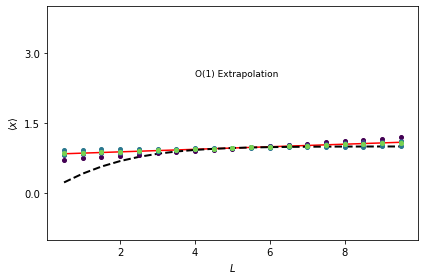

In [25]:
fig, ax = plt.subplots()

#nsampvals = np.geomspace(10, len(xdata), num=4, dtype=int)
nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
ax.plot(lvals, mIG.avgX(1.0, L=lvals), 'k--', linewidth=2.0)

#And the infinite sampling results for first order extrapolation
trueExtrap, trueDerivs = mIG.extrapAnalyticVolume(lvals, refLength, 1)
ax.plot(lvals, trueExtrap, 'r-', zorder=0)
print('True extrapolation coefficients: %s'%str(trueDerivs))

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdataL), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    thisext = extModelVol.train(refBeta, xdataL[thisinds], wdataL[thisinds], saveParams=False)
    print('\t With N_configs = %6i: %s'%(n, str(thisext.flatten()))) #Have to flatten because observable is 1-D
    dataExtrap = extModelVol.predict(lvals, params=thisext)
    ax.plot(lvals, dataExtrap, 'o', markersize=4, color=nsampcolors[i], label='N=%i'%n)

ax.set_ylabel(r'$\langle x \rangle$')
ax.set_xlabel(r'$L$')

ax.annotate('O(1) Extrapolation', xy=(0.4, 0.7), xycoords='axes fraction', fontsize=9)

ax.set_ylim((-1.0, 4.0))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()


## Interpolation

### Classes used for interpolation

Instead of performing extrapolation, we can also perform interpolation. Classes already exist for this, namely `ExtrapWeightedModel`, `InterpModel`, and `MBARModel`. The first implements extrapolation from two points weighted with a Minkowski-like distance, the second polynomial interpolation from any number of points, and the last uses reweighting with MBAR from multiple points.

With the exception of `MBARModel` all of these classes inherited `ExtrapModel` and then modified three methods: `train`, `predict`, and `resampleData`. The last only needed to be modified to resample data from multiple state points, which is allowed in these types of models. `train` is what is used to determine the parameters for the model, such as derivatives or polynomial coefficients. `predict` makes a prediction based on parameters determined during training. At this point we've covered pretty much everything that makes up an extrapolation/interpolation class except for the `bootstrap` method.

Demonstrations of creating and using `InterpModel` and `MBARModel` classes are shown below.

In [26]:
#Generate data at two extreme beta values
xdata1, udata1 = mIG.genData(betavals[0], nConfigs=10000)
xdata2, udata2 = mIG.genData(betavals[-1], nConfigs=10000)
xData = np.array([xdata1, xdata2])
uData = np.array([udata1, udata2])


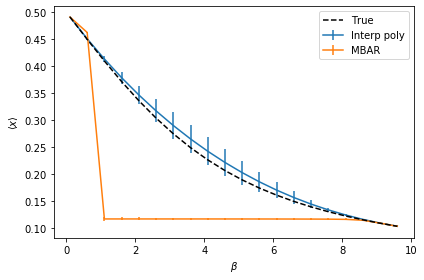

In [27]:
#Create the class objects - no need to go to high order here
iModelPoly = InterpModel(refB=[betavals[0], betavals[-1]], xData=xData, uData=uData, maxOrder=2)

#And plot results, using bootstrapped error on same dataset for each type of model
iFig, iAx = plt.subplots()

iAx.errorbar(betavals, iModelPoly.predict(betavals, order=1)[:,0], 
             yerr=iModelPoly.bootstrap(betavals, order=1)[:,0], label='Interp poly')

#Add on MBAR if possible
try:
    #With MBAR it is recommended to ignore some numpy warnings
    with np.errstate(invalid='ignore'):
        iModelMBAR = MBARModel(refB=[betavals[0], betavals[-1]], xData=xData, uData=uData)
    with np.errstate(invalid='ignore'):
        iAx.errorbar(betavals, iModelMBAR.predict(betavals, order=1)[:,0], 
                     yerr=iModelMBAR.bootstrap(betavals, order=1)[:,0], label='MBAR')
except NameError:
    pass
    
#And plot the true values
iAx.plot(betavals, mIG.avgX(betavals), 'k--', label='True', zorder=3)

iAx.set_xlabel(r'$\beta$')
iAx.set_ylabel(r'$\langle x \rangle$')
iAx.legend()

iFig.tight_layout()

plt.show()


The above compares polynomial interpolation and MBAR (really just BAR because using only 2 points). Both methods are used to interpolate between the two extreme values of beta. In both cases, the same data from the two edge points is used, making use of only derivatives up to 1st order for interpolation. The error bars are one standard deviation from bootstrap resampling of the predictions of each model. True values are represented by the black dashed line.

We don't really expect MBAR to do any better than perturbation because it is using the MBAR weights between states to reweight the perturbation theory estimates. As such, we can see that it is "sticky" in that it tries to keep using a single point until it suddenly jumps to the next one. This is a symptom of the fact that the perturbation theory estimates themselves plateau. Such plateaus represent poor overlap, resulting in large free energy differences and MBAR weights that essentially act as step functions (i.e. you just pick whichever point has lower free energy over the entire interval). Extrapolation is almost always better, but note that it's predictions vary more with sampling, especially if you go to higher order.

### Recursive interpolation

Also included in the library is a function to perform recursive interpolation to achieve estimates over an interval to a specified error tolerance. The model class that does this is called `RecursiveInterp`. One of the inputs to this class is an interpolation class object (trained or not), such as `InterpModel`. This function continues picking new points and dividing the original interval until all points satisfy the error tolerance, which is represented as a relative error. Details of the algorithm are provided below.

A key feature of `RecursiveInterp` is a method called `getData`. Simply put, this obtains data if provided a value of the variable over which we're extrapolating. By default, this method is just set up to return data at a specified $\beta$ for the 1D ideal gas model, so we don't need to touch it. However, in the paper we modify this method to load in data from an MD simulation of water closest to the specified state point. If you want to generate new MD or MC data on the fly, you will need to create a new class that inherits from `RecursiveInterp` and just change the `getData` method to run the appropriate simulation and load in the data you need.


Interpolating from points 0.100000 and 9.600000
Recursion depth on this branch: 0
Maximum bootstrapped error within interval: 0.119663
Selected new extrapolation point: 4.753061


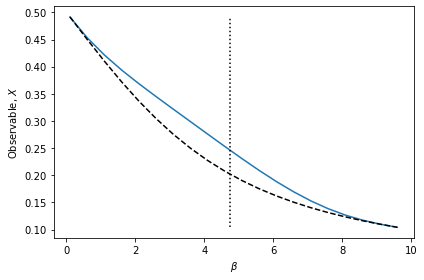


Interpolating from points 0.100000 and 4.753061
Recursion depth on this branch: 1
Maximum bootstrapped error within interval: 0.020281
Selected new extrapolation point: 2.284090


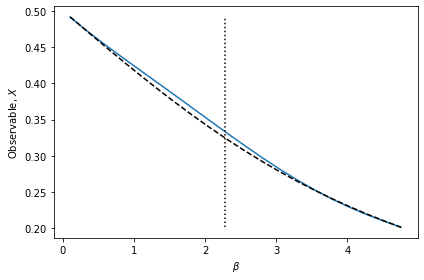


Interpolating from points 0.100000 and 2.284090
Recursion depth on this branch: 2
Maximum bootstrapped error within interval: 0.004643
No additional extrapolation points necessary on this interval.


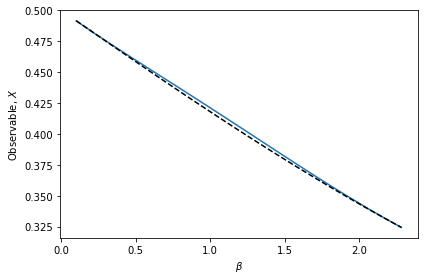


Interpolating from points 2.284090 and 4.753061
Recursion depth on this branch: 2
Maximum bootstrapped error within interval: 0.005917
No additional extrapolation points necessary on this interval.


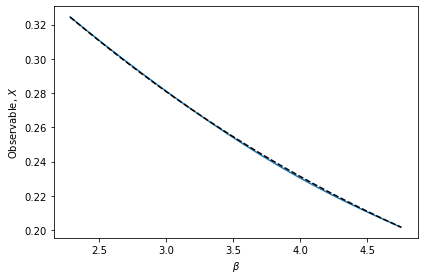


Interpolating from points 4.753061 and 9.600000
Recursion depth on this branch: 1
Maximum bootstrapped error within interval: 0.014429
No additional extrapolation points necessary on this interval.


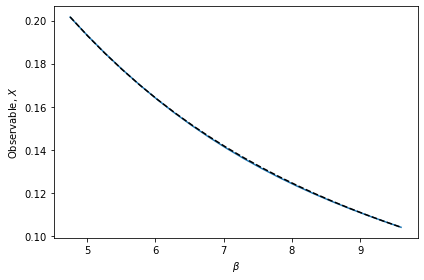

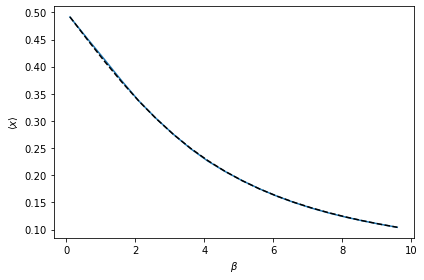

In [28]:
plt.ioff()

#Now want to look at recursive interpolation procedure
#Will only use polynomial interpolation model here
iModelPoly = InterpModel(maxOrder=2)

#Create the recursive model
intPpiecewise = RecursiveInterp(iModelPoly, [betavals[0], betavals[-1]], maxOrder=1, errTol=0.02)

#Train it recursively until error tolerance reached
#Turn off verbose or doPlot if don't want to see progress of algorithm
#plotCompareFunc provides the true values to compare to in the figure
intPpiecewise.recursiveTrain(betavals[0], betavals[-1], verbose=True, doPlot=True, plotCompareFunc=mIG.avgX)

#Obtain predictions from our model, which will be based on piecewise interpolating polynomials
intPpredict = intPpiecewise.predict(betavals)[:,0]

#Plot to compare against true average versus beta for ideal gas model
plt.ion()
interpFig, interpAx = plt.subplots()

interpAx.plot(betavals, intPpredict)
interpAx.plot(betavals, mIG.avgX(betavals), 'k--', zorder=3)

interpAx.set_ylabel(r'$\langle x \rangle$')
interpAx.set_xlabel(r'$\beta$')

interpFig.tight_layout()

plt.show()


The above cell runs an automated algorithm for performing interpolation recursively. In the above example, polynomial interpolation is used. This is recommended, but the algorithm may also use weighted extrapolation or MBAR. In the figure, the true observable is shown as the dashed black line. The blue line is final result of the recursive algorithm. Note that there is no bootstrap method for `RecursiveInterp` since the algorithm guarantees the uncertainty to be within the tolerance.

A sketch of the recursive algorithm is as follows:

1. Perform interpolation between edge points
    * Only uses up to maximum desired order of derivative information. In the simple ideal gas model, it requires prohibitive amounts of sampling to get good accuracy of derivatives above order 2. If using polynomial interpolation, 2nd derivatives will give us order 5 polynomials. In practice, this probably isn't necessary, so settling for the much more accurate 3rd order interpolating polynomials, which only make use of 1st derivatives.
    * Needs input data at each edge point or must modify getData method in the RecursiveInterp class to read in data or perform simulations. As a default, this class just uses the toy ideal gas model to generate data.
  
  
2. Calculate bootstrapped uncertainty over whole interval
    * The region between the edge points is gridded up with the interpolation model used to predict the value at each point. This procedure is bootstrapped by resampling the data to get the standard deviation of each predicted value at each grid point. The absolute relative error is defined as $\frac{\sigma_x}{|x|}$. The maximum relative error over all grid points and observable elements (if the observable is a vector) is found and compared to the desired tolerance. 
  
  
3. Check if maximum uncertainty is within tolerance
    * If the maximum absolute relative error within the region is lower than the tolerance, then no new simulations are needed. If it is larger than the tolerance, a new state-point is selected where the absolute relative error is a maximum.
  
  
4. Add state point if necessary and recurse
    * If the tolerance is not met, a state point is added as described above. The algorithm returns to step one for each subinterval created, with new data only generated at the new point.

It is a good idea when using the recursive algorithm to visually check for consistency.

Interval with edges [0.1        2.28408996 4.75306122] (indices [0 1 2]):
	P-values between regions:
[[0.50921088]
 [0.53646568]
 [0.51925634]
 [0.39440291]
 [0.05710045]
 [0.22910975]]
	P-values for full and 1 :
[[0.02470673]
 [0.05506846]
 [0.11678695]
 [0.41693306]
 [0.49104987]
 [0.43813257]]
	P-values for full and 2 :
[[0.50923217]
 [0.53688265]
 [0.52715399]
 [0.50946924]
 [0.4938618 ]
 [0.48333894]]
Interval with edges [2.28408996 4.75306122 9.6       ] (indices [1 2 3]):
	P-values between regions:
[[0.32508698]
 [0.44685111]
 [0.53944306]
 [0.60150529]
 [0.65086447]
 [0.69362505]]
	P-values for full and 1 :
[[0.41759923]
 [0.47238261]
 [0.5316086 ]
 [0.59082942]
 [0.64416404]
 [0.69014966]]
	P-values for full and 2 :
[[0.10951665]
 [0.1022089 ]
 [0.10189719]
 [0.10321687]
 [0.10462711]
 [0.10579778]]


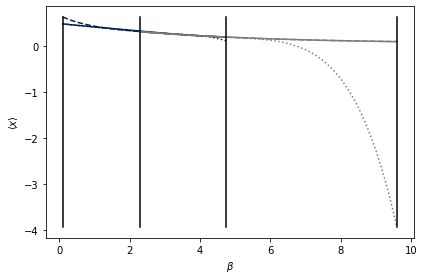

In [29]:
#Can also check for consistency of local curvature
#Not implemented as an "optimization" rule in the recursive interpolation procedure
#But do have function to do statistical and visual check

#Using the model we just trained above, so must run cell above before this one
checkPvals = intPpiecewise.checkPolynomialConsistency(doPlot=True)


In the above plot, interpolating polynomials are shown for sliding windows of three state points used in the recursive interpolation model. Colors change for each window. Within a window (same color) the interpolating polynomial for the lower subregion is shown with a dotted line, that for the upper subregion with a dashed line, and the whole window region using the two outermost edge points with a solid line. Outside of the region they were fitted over, the polynomials show large deviations from the true values. For interpolation, however, the polynomials all overlap quite well. By construction, the piecewise function created by the recursive procedure is continuous in both its value and first derivative at all points in the entire interval. Using higher order derivative information would result in continuity in even higher derivatives, but likely even more divergent behavior outside of the interpolated range.

The point of the above consistency check is to see if the local polynomials agree within each sliding window. If they do, then that means the local curvature is the same over that region and is captured by the order of polynomial that is fit there. To this end, the polynomial coefficients are also boostrapped and, assuming Normal distributions, p-values are computed for the null hypothesis that the coefficients for each set of sub-regions and the full region within a window are the same. Since we want the polynomials to be the same, we don't want small p-values, so the test is of limited usefulness as larger p-values don't necessarily imply greater similarity. A better statistical test is thus needed. However, the visualization provides a quick visual check/rule of thumb to gauge the consistency of the local curvature and thus convergence of the algorithm. This is similar to the idea of generating overlapping distributions for umbrella sampling.